The goal of this notebook is to show that the intra-individual variation of the same site is larger than the inter-individual variation of different sites.

In other words, we want to explicitly show that in the aerodigestive tract, different sites are more similar to each other within a patient than to the same sites in other patients - in the aerodigestive tract, communities cluster by patient rather than by site.

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import wilcoxon

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Read in data and clean up samples

In [2]:
fjsdlong = '/Users/claire/github/aspiration-analysis/data/analysis/jsd.txt'
fnmeta = '/Users/claire/github/aspiration-analysis/data/clean/rosen.metadata.clean'

jsd = pd.read_csv(fjsdlong, sep='\t')
meta = pd.read_csv(fnmeta, sep='\t', index_col=0)

/Users/claire/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Remove "final" throat and stool samples
print(jsd.shape[0])
jsd = jsd[~jsd['sample1'].str.endswith('F')]
print(jsd.shape[0])
jsd = jsd[~jsd['sample2'].str.endswith('F')]
print(jsd.shape[0])
jsd = jsd[~jsd['sample1'].str.endswith('sick')]
print(jsd.shape[0])
jsd = jsd[~jsd['sample2'].str.endswith('sick')]
print(jsd.shape[0])
jsd = jsd[~jsd['sample1'].str.endswith('F2')]
jsd = jsd[~jsd['sample1'].str.endswith('F2T')]
jsd = jsd[~jsd['sample2'].str.endswith('F2')]
jsd = jsd[~jsd['sample2'].str.endswith('F2T')]
print(jsd.shape[0])
jsd = jsd[~jsd['sample1'].str.startswith('05')]
jsd = jsd[~jsd['sample2'].str.startswith('05')]
print(jsd.shape[0])

106030
106030
106030
106030
106030
106030
106030


In [4]:
# Keep just within-batch comparisons
jsd2014 = jsd.query('(batch1 == 2014) & (batch2 == 2014)')
jsd2016 = jsd.query('(batch1 == 2016) & (batch2 == 2016)')
print(jsd2014.shape[0], jsd2016.shape[0])

jsd = pd.concat((jsd2014, jsd2016))
print(jsd.shape)

(51040, 9870)
(60910, 39)


In [5]:
jsd.groupby(['batch1', 'batch2', 'patient_comp', 'site_comparison']).size()

batch1  batch2  patient_comp  site_comparison            
2014    2014    between       bal-bal                        3240
                              bal-gastric_fluid              4441
                              bal-stool                       220
                              bal-throat_swab                5034
                              gastric_fluid-bal              3911
                              gastric_fluid-gastric_fluid    5356
                              gastric_fluid-stool             297
                              gastric_fluid-throat_swab      6164
                              stool-bal                       671
                              stool-gastric_fluid             847
                              stool-stool                      55
                              stool-throat_swab               913
                              throat_swab-bal                4950
                              throat_swab-gastric_fluid      6648
                  

# Sample code with one patient

What we want to show is: the distribution of JSD's between that patient's lung and all other lungs, with the patient's lung-throat and lung-gastric JSD overlaid.

1. Get all lung-lung JSD from that patient and all other patients   
2. Make histogram of those   
3. Overlay that patient's lung-gastric and lung-throat JSD

In [6]:
# Get a patient who has all three sites
subj = '04-172-0'
samples = list(set(
    jsd.query('subject == @subj')['sample1'].tolist() 
    + jsd.query('subject == @subj')['sample2'].tolist()
    ))
samples

['04-172-0G', '04-172-0T', '04-172-0B']

In [7]:
smpl = '04-172-0B'


# Query bal-bal comparisons including this person's bal sample
balbal = jsd\
    .query('(sample1 == @smpl) | (sample2 == @smpl)')\
    .query('site_comparison == "bal-bal"')
    
balgas = jsd.query('subject == @subj').query('site_comparison == "bal-gastric_fluid"')['beta'].values
balthr = jsd.query('subject == @subj').query('site_comparison == "bal-throat_swab"')['beta'].values
print(balgas, balthr)

(array([0.87107771]), array([0.93985078]))


/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


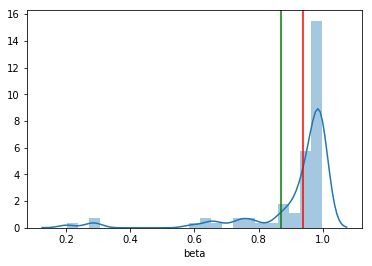

In [8]:
fig, ax = plt.subplots()
sns.distplot(balbal['beta'], ax=ax)
ax.axvline(balgas, color='g')
ax.axvline(balthr, color='r')

In [9]:
balbal.shape

(80, 39)

Let's do this systematically.

```
For each patient:
    for each site in that patient:
        get all the between-patient, within-batch site-site comparisons (i.e. same site, different patients)
        for each within-patient site comparisons for that patient:
            count how many btw patient site-site jsd's are lower than that site-comparison jsd
            
            store: [subject, site, sample-of-that-site, 
                    N btw patient same site comparisons, 
                    site-comparison, N jsd within < jsd between]
```

# Code for all patients

2019-01-16 Note: I found a bug in this code. There should be an additional

```
.query('(sample1 == @s1) | (sample2 == @s1)')
```

When `sitejsd` gets defined...

AKA **THIS CODE IS NOT CORRECT DO NOT USE IT**

(Keeping it here for my records, in case I need to reproduce the bug without digging through git diffs of notebooks...)

The code that I will actually use to make the final version of the figure is in `within_beta_vs_between_beta.py`.

In [10]:
allcomps = ['gastric_fluid-throat_swab', 'bal-gastric_fluid', 'bal-throat_swab']

reslst = []
for subj, ptjsd in jsd.query('site_comparison == @allcomps').groupby('subject'):
    samples = list(set(ptjsd['sample1'].tolist() + ptjsd['sample2'].tolist()))
    for s in samples:
        site = meta.loc[s, 'site']
        
        # between patients, same site comparison
        site_comp = site + '-' + site
        sitejsd = jsd\
            .query('patient_comp == "between"')\
            .query('site_comparison == @site_comp')

        # get the site comparisons that include that site
        relevant_comps = [i for i in ptjsd['site_comparison'] if site in i]
        
        # get the within-patient beta div for each of those comparisons
        for comp in relevant_comps:
            
            # get the site1-site2 within patient jsd
            beta = ptjsd.query('site_comparison == @comp')['beta'].values[0]
            
            # how many site-site jsd's are lower than this within-patient one?
            n = sum(sitejsd['beta'] < beta)
            
            # mean(patient's lung vs all other lungs) - site1-site2 within jsd
            diff = np.mean(sitejsd['beta']) - beta
            
            # Prepare data to store
            row = [subj, site, s, sitejsd.shape[0], comp, beta, n, diff]
            reslst.append(row)


In [11]:
# Note: "n_lower" means "number of inter-patient comparisons (site1 vs site1) which
# were more similar than that patient's respective intra-patient comparison (site1 vs. site2)"
resdf = pd.DataFrame(
    reslst, 
    columns=['subject', 'site', 'sample', 
             'n_btw_patient', 'site_comparison', 
             'beta', 'n_lower', 'inter_minus_intra'])
resdf['percent_lower'] = resdf['n_lower']/resdf['n_btw_patient'].astype(float)

In [12]:
resdf.head()

,subject,site,sample,n_btw_patient,site_comparison,beta,n_lower,inter_minus_intra,percent_lower
0,01-112-7,throat_swab,01-112-7TI,8952,gastric_fluid-throat_swab,0.993353,8952,-0.393382,1.000000
1,01-112-7,gastric_fluid,01-112-7GI,6259,gastric_fluid-throat_swab,0.993353,6183,-0.228705,0.987857
2,01-164-7,throat_swab,01-164-7TI,8952,gastric_fluid-throat_swab,0.091874,0,0.508098,0.000000
3,01-164-7,gastric_fluid,01-164-7GI,6259,gastric_fluid-throat_swab,0.091874,0,0.672775,0.000000
4,01-173-4,gastric_fluid,01-173-4G,6259,gastric_fluid-throat_swab,0.516810,453,0.247839,0.072376


In [13]:
resdf.groupby(['site', 'site_comparison']).describe()[['percent_lower']]

percent_lower                      \
                                                count      mean       std   
site          site_comparison                                               
bal           bal-gastric_fluid                  89.0  0.205449  0.212084   
              bal-throat_swab                    73.0  0.524046  0.353704   
gastric_fluid bal-gastric_fluid                  89.0  0.262626  0.282363   
              gastric_fluid-throat_swab         112.0  0.241512  0.298318   
throat_swab   bal-throat_swab                    73.0  0.773787  0.326049   
              gastric_fluid-throat_swab         112.0  0.424450  0.362196   

                                                                       \
                                              min       25%       50%   
site          site_comparison                                           
bal           bal-gastric_fluid          0.000290  0.055942  0.103768   
              bal-throat_swab            0.018551  0.154783  0.547246   
gastric_fluid bal-gastric_fluid          0.000000  0.023167  0.111040   
              gastric_fluid-throat_swab  0.000000  0.014339  0.120227   
throat_swab   bal-throat_swab            0.000559  0.608021  0.981680   
              gastric_fluid-throat_swab  0.000000  0.047001  0.426664   

                                                             
                                              75%       max  
site          site_comparison                                
bal           bal-gastric_fluid          0.344348  0.782899  
              bal-throat_swab            0.868406  0.999710  
gastric_fluid bal-gastric_fluid          0.548330  0.872823  
              gastric_fluid-throat_swab  0.389799  0.998243  
throat_swab   bal-throat_swab            0.998436  1.000000  
              gastric_fluid-throat_swab  0.759970  1.000000

/Users/claire/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


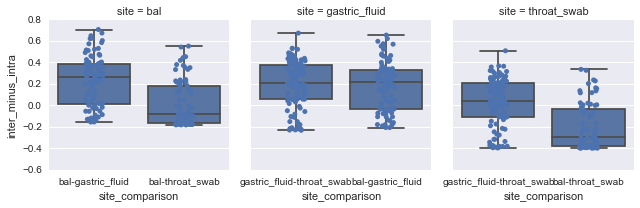

In [14]:
order = ['bal', 'gastric_fluid', 'throat_swab']
g = sns.FacetGrid(data=resdf, col='site', sharex=False, col_order=order)
g.map(sns.boxplot, 'site_comparison', 'inter_minus_intra')
g.map(sns.stripplot, 'site_comparison', 'inter_minus_intra', jitter=True)


For each plot, the values are the difference between that patient's mean similarity to all other patient's site and that patients' similarity with the other site.

So if it's above zero, that means that on average, the within-patient communities are more similar than the between-patient comparison.

If it's below zero, that means that the within-patient are more **different** than similarities in sites between patients.

In [15]:
for site, subdf in resdf.groupby(['site', 'site_comparison']):
    print(site[0], site[1], wilcoxon(subdf['inter_minus_intra']))

('bal', 'bal-gastric_fluid', WilcoxonResult(statistic=335.0, pvalue=8.9615125006500538e-12))
('bal', 'bal-throat_swab', WilcoxonResult(statistic=1293.0, pvalue=0.75191941810426355))
('gastric_fluid', 'bal-gastric_fluid', WilcoxonResult(statistic=541.0, pvalue=2.2388416416502762e-09))
('gastric_fluid', 'gastric_fluid-throat_swab', WilcoxonResult(statistic=742.0, pvalue=2.045078671169907e-12))
('throat_swab', 'bal-throat_swab', WilcoxonResult(statistic=295.0, pvalue=6.5267017957769836e-09))
('throat_swab', 'gastric_fluid-throat_swab', WilcoxonResult(statistic=2543.0, pvalue=0.071412991678381596))


Lungs are more different from other lungs than lungs and stomachs are within people.

(Lungs are not necessarily more different from other lungs than lungs and throats are within people.)

Stomachs are more different between people than they are to both throats and lungs within people.

Throats are more similar between people than lungs and throats within people.

Throats between people are basically as different/similar as throats and stomachs within people.